<a href="https://colab.research.google.com/github/hamuim/Patern-idea-TensorFlow/blob/main/HWSH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/hamuim/Patern-idea-TensorFlow

Cloning into 'Patern-idea-TensorFlow'...
remote: Enumerating objects: 58, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 58 (delta 18), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (58/58), 143.31 KiB | 744.00 KiB/s, done.
Resolving deltas: 100% (18/18), done.


In [2]:
import sys
sys.path.append("Patern-idea-TensorFlow")

In [3]:
import tensorflow as tf
tf.random.set_seed(42)

In [4]:
try:
    tpu = None
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.MirroredStrategy()

In [5]:
import matplotlib.pyplot as plt
import rn10
import ut
import time

In [6]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 4s 0us/step


In [7]:
import numpy as np

con_x = np.concatenate((x_train, x_test), axis=0)
con_y = np.concatenate((y_train, y_test), axis=0)
x_train = con_x
y_train = con_y

In [8]:
BATCH_SIZE = 64 * strategy.num_replicas_in_sync
AUTO = tf.data.AUTOTUNE

def scale(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)
    label = tf.cast(label, tf.int32)
    return image, label

def augment(image,label):
    image = tf.image.resize_with_crop_or_pad(image, 40, 40)
    image = tf.image.random_crop(image, size=[32, 32, 3])
    image = tf.image.random_brightness(image, max_delta=0.5)
    image = tf.clip_by_value(image, 0., 1.)

    return image, label

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = (
    train_ds
    .shuffle(1024)
    .map(scale, num_parallel_calls=AUTO)
    .map(augment, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_ds = (
    test_ds
    .map(scale, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

In [9]:
import tensorflow as tf
tf.config.run_functions_eagerly(False)

class HWSHModel(tf.keras.Model):
    def __init__(self, resnet_model, rho=0.06):
        super(HWSHModel, self).__init__()
        self.resnet_model = resnet_model
        self.rho = rho

    def train_step(self, data):
        (images, labels) = data
        e_ws = []
        with tf.GradientTape() as tape:
            predictions = self.resnet_model(images)
            loss = self.compiled_loss(labels, predictions)
        trainable_params = self.resnet_model.trainable_variables
        gradients = tape.gradient(loss, trainable_params)
        grad_norm = self._grad_norm(gradients)
        scale = self.rho / (grad_norm + 1e-12)

        for (grad, param) in zip(gradients, trainable_params):
            e_w = grad * scale
            param.assign_add(e_w)
            e_ws.append(e_w)

        with tf.GradientTape() as tape:
            predictions = self.resnet_model(images)
            loss = self.compiled_loss(labels, predictions)

        sam_gradients = tape.gradient(loss, trainable_params)
        for (param, e_w) in zip(trainable_params, e_ws):
            param.assign_sub(e_w)

        self.optimizer.apply_gradients(
            zip(sam_gradients, trainable_params))

        self.compiled_metrics.update_state(labels, predictions)
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        (images, labels) = data
        predictions = self.resnet_model(images, training=False)
        loss = self.compiled_loss(labels, predictions)
        self.compiled_metrics.update_state(labels, predictions)
        return {m.name: m.result() for m in self.metrics}

    def _grad_norm(self, gradients):
        norm = tf.norm(
            tf.stack([
                tf.norm(grad) for grad in gradients if grad is not None
            ])
        )
        return norm

In [10]:
train_callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=10,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5,
        patience=3, verbose=1
    )
]

In [11]:
with strategy.scope():
    model = HWSHModel(ut.get_training_model())

model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

start = time.time()
history = model.fit(train_ds,
                   validation_data=test_ds,
                   callbacks=train_callbacks,
                   epochs=35)

Epoch 1/35
938/938 [==============================] - 134s 111ms/step - loss: 2.2082 - accuracy: 0.1752 - val_loss: 1.7182 - val_accuracy: 0.3712 - lr: 0.0010
Epoch 2/35
938/938 [==============================] - 101s 107ms/step - loss: 1.7486 - accuracy: 0.3176 - val_loss: 1.4911 - val_accuracy: 0.4556 - lr: 0.0010
Epoch 3/35
938/938 [==============================] - 101s 107ms/step - loss: 1.5689 - accuracy: 0.4013 - val_loss: 1.3189 - val_accuracy: 0.5238 - lr: 0.0010
Epoch 4/35
938/938 [==============================] - 101s 108ms/step - loss: 1.4128 - accuracy: 0.4659 - val_loss: 1.1543 - val_accuracy: 0.5866 - lr: 0.0010
Epoch 5/35
938/938 [==============================] - 101s 107ms/step - loss: 1.2769 - accuracy: 0.5194 - val_loss: 1.0040 - val_accuracy: 0.6438 - lr: 0.0010
Epoch 6/35
938/938 [==============================] - 101s 108ms/step - loss: 1.1525 - accuracy: 0.5662 - val_loss: 0.9178 - val_accuracy: 0.6759 - lr: 0.0010
Epoch 7/35
938/938 [==========================

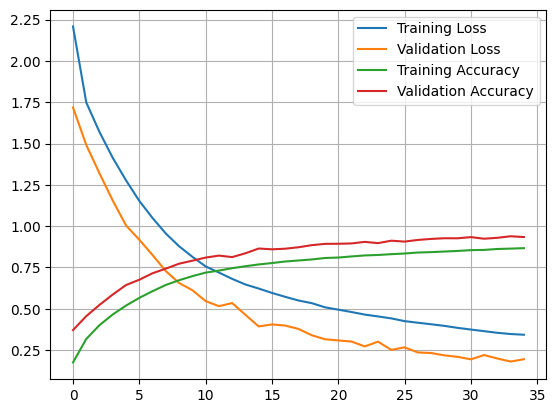

In [12]:
ut.plot_history(history)

In [13]:
with strategy.scope():
    model = ut.get_training_model()

model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

start = time.time()
history = model.fit(train_ds,
                   validation_data=test_ds,
                   callbacks=train_callbacks,
                   epochs=25)
print(f"Total training time: {(time.time() - start)/60.} minutes")

Epoch 1/25
938/938 [==============================] - 72s 59ms/step - loss: 1.4811 - accuracy: 0.4570 - val_loss: 1.1256 - val_accuracy: 0.6036 - lr: 0.0010
Epoch 2/25
938/938 [==============================] - 54s 58ms/step - loss: 1.0444 - accuracy: 0.6291 - val_loss: 1.4169 - val_accuracy: 0.5611 - lr: 0.0010
Epoch 3/25
938/938 [==============================] - 54s 57ms/step - loss: 0.8643 - accuracy: 0.6970 - val_loss: 1.6619 - val_accuracy: 0.5673 - lr: 0.0010
Epoch 4/25
938/938 [==============================] - 54s 57ms/step - loss: 0.7466 - accuracy: 0.7387 - val_loss: 0.7565 - val_accuracy: 0.7258 - lr: 0.0010
Epoch 5/25
938/938 [==============================] - 54s 58ms/step - loss: 0.6651 - accuracy: 0.7677 - val_loss: 0.6531 - val_accuracy: 0.7688 - lr: 0.0010
Epoch 6/25
938/938 [==============================] - 54s 58ms/step - loss: 0.6131 - accuracy: 0.7878 - val_loss: 0.6498 - val_accuracy: 0.7845 - lr: 0.0010
Epoch 7/25
938/938 [==============================] - 54s 

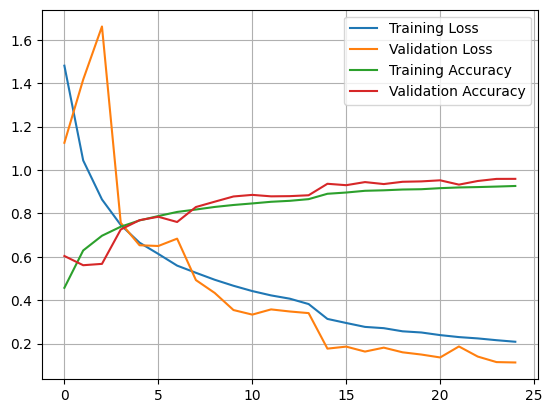

In [14]:
ut.plot_history(history)